# 7. 함수 데커레이터와 클로저
* 목차:
    - 7.1. 데커레이터 기본 지식
    - 7.2. 데커레이터 실행 시점
    - 7.3. 데커레이터로 개선한 전략 패턴
    - 7.4. 변수 범위 규칙
    - 7.5. 클로저
    - 7.6. nonlocal
    - 7.7. 간단한 데커레이터 구현
    - 7.8. 표준 라이브러리에서 제공하는 데커레이터
    - 7.9. 누적된 데커레이터
    - 7.10. 매개변수화된 데커레이터
    - 7.11. 요약

In [1]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def load_img(file, img_dir='fig/'):
    img = misc.imread(img_dir + file)
    plt.imshow(img)
    plt.subplots_adjust(right=2, top=2)

## 7.1. 데커레이터
* 다른 함수를 인수로 받는 **콜러블**
* 데커레이트된 함수에 어떤 처리를 수행하고,
    - 함수를 반환하거나
    - 다른 함수나 콜러블 객체로 대체
* 아래 둘은 동일

``` python
@decorate
def target():
    print('running target()')
```

``` python
def target():
    print('running target()')
    
target = decorate(target)
```

* 예제 7-1.
    - target은 inner를 가리키고 있음
    - 일반적인 콜러블과 동일하지만 런타임에 프로그램 행위를 변경하는 메타프로그래밍을 할때 상당히 편리

In [2]:
def deco(func):
    def inner(x):
        print('running inner()')
        return 2*func(x)
    return inner
  
@deco
def target(x):
    print('running target()')
    return 1

In [3]:
print(target(2))

running inner()
running target()
2


In [20]:
print(target)

<function deco.<locals>.inner at 0x7fc27d2e6620>


* 요약:
    1. 데커레이터는 함수를 다른 함수로 대체
    2. 데커레이터는 **모듈이 로딩되는 시점**에 실행됨

## 7.2. 파이썬이 데커레이터 실행하는 시점

In [4]:
! cat registration.py

# -*- coding: utf-8 -*-

registry = []

def register(func):
    print('running register(%s)' % func)
    registry.append(func)
    return func


@register
def f1():
    print('running f1()')


@register
def f2():
    print('running f2()')


def f3():
    print('running f3()')



def main():
    print('runnning main()')
    print('registry ->', registry)
    f1()
    f2()
    f3()


if __name__ == '__main__':
    main()


In [22]:
! python registration.py

running register(<function f1 at 0x7f57f3e18620>)
running register(<function f2 at 0x7f57f298dae8>)
runnning main()
registry -> [<function f1 at 0x7f57f3e18620>, <function f2 at 0x7f57f298dae8>]
running f1()
running f2()
running f3()


In [23]:
import registration

running register(<function f1 at 0x7fc27d2e6598>)
running register(<function f2 at 0x7fc27d2e68c8>)


In [24]:
registration.registry

[<function registration.f1>, <function registration.f2>]

* 요약:
    - 함수 데커레이터는 모듈이 임포트 되자마자 실행 (import time)
    - 데커레이트된 함수는 명시적으로 호출될때만 실행됨 (run time)
    - 이 예제에서 데커레이터 함수는 데커레이트된 함수를 그대로 반환하지만 일반적으로는 내부 함수를 정의해서 이를 반환함

## 7.3. 데커레이터로 개선한 전략 패턴

In [5]:
promos = []

def promotion(promo_func):
    promos.append(promo_func)
    return promo_func


@promotion
def fidelity(order):
    return order.total() * 0.05 if order.customer.fidelity >= 1000 else 0


@promotion
def bulk_item(order):
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * 0.1
    return discount


@promotion
def large_order(order):
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * 0.07
    return 0


def best_promo(order):
    return max(promo(order) for promo in promos)

In [7]:
print(promos)

[<function fidelity at 0x11d737c80>, <function bulk_item at 0x11d737d08>, <function large_order at 0x11d737bf8>]


## 7.4. 변수 범위 규칙
* 대부분의 데커레이터는 내부 함수를 정의하고 데커레이트된 함수를 대체함  
$\Rightarrow$ 거의 항상 클로저에 의존
* 이를 이해하기 위해 변수 범위의 작동 방식에 대한 이해 필요

In [27]:
def f1(a):
    print(a)
    print(b)

In [28]:
print(f1(3))

3


NameError: name 'b' is not defined

In [29]:
b = 6
print(f1(3))

3
6
None


In [82]:
b = 6
def f2(a):
    print(a)
    print(b)
    b = 9
    
print(f2(3))

3


UnboundLocalError: local variable 'b' referenced before assignment

* 요약:
    - 파이썬이 본체 함수를 컴파일할 때 b가 함수 안에서 할당되므로, b를 지역 변수로 판단
    - 함수 본체 안에서 할당된 변수는 지역 변수로 판단함
* 인터프리터가 b를 전역 변수로 다루길 원하면 아래와 같이 global 키워드를 이용해 선언

In [31]:
b = 6
def f3(a):
    global b
    print(a)
    print(b)
    b = 9

print('==='*3)
print(f3(3))

print('==='*3)
print(b)

print('==='*3)
b = 30
print(b)

3
6
None
9
30


* 디스어셈블리 코드 비교

In [35]:
from dis import dis

* 지역명 a, 전역명 b

In [36]:
print(dis(f1))

  2           0 LOAD_GLOBAL              0 (print)
              2 LOAD_FAST                0 (a)
              4 CALL_FUNCTION            1
              6 POP_TOP

  3           8 LOAD_GLOBAL              0 (print)
             10 LOAD_GLOBAL              1 (b)
             12 CALL_FUNCTION            1
             14 POP_TOP
             16 LOAD_CONST               0 (None)
             18 RETURN_VALUE
None


* 지역명 a, b

In [37]:
print(dis(f2))

  3           0 LOAD_GLOBAL              0 (print)
              2 LOAD_FAST                0 (a)
              4 CALL_FUNCTION            1
              6 POP_TOP

  4           8 LOAD_GLOBAL              0 (print)
             10 LOAD_FAST                1 (b)
             12 CALL_FUNCTION            1
             14 POP_TOP

  5          16 LOAD_CONST               1 (9)
             18 STORE_FAST               1 (b)
             20 LOAD_CONST               0 (None)
             22 RETURN_VALUE
None


## 7.5. 클로저
* 클로저: 함수 본체에서 정의하지 않고 참조하는 비전역(nonglobal) 변수를 포함한 확장 범위를 가진 함수
* 함수 본체 외부에 정의된 비전역 변수에 접근할 수 있음
* 함수를 정의할 때 존재하던 자유 변수에 대한 바인딩을 유지하는 함수
    - 함수를 정의하는 범위가 사라진 후에 함수를 호출해도 자유 변수에 접근 가능
    - 함수가 비전역 외부 변수를 다루는 경우는 그 함수가 다른 함수 안에 정의된 경우뿐임

/home/yjlee/venvs/youjin2_py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


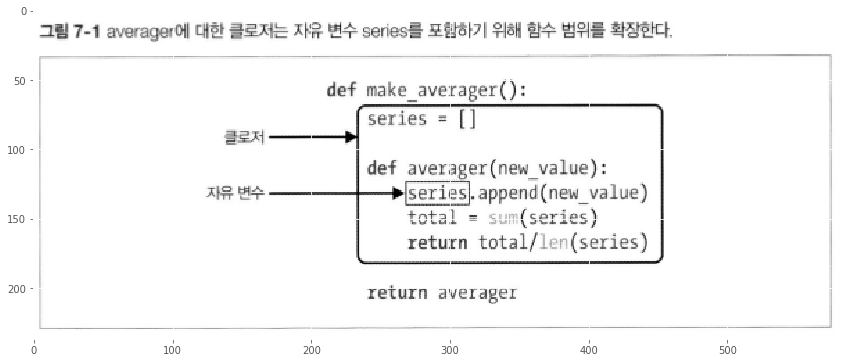

In [39]:
load_img('fig7-1.png')

* 예 7-9

In [40]:
class Averager(object):
    
    def __init__(self):
        self.series = []
        
    def __call__(self, new_value):
        self.series.append(new_value)
        total = sum(self.series)
        return total / len(self.series)

In [41]:
avg = Averager()
print('===' * 3)
print(avg(10))
print(avg.series)

print('===' * 3)
print(avg(11))
print(avg.series)

print('===' * 3)
print(avg(12))
print(avg.series)

10.0
[10]
10.5
[10, 11]
11.0
[10, 11, 12]


* 예 7-10
    - series: 자유 변수 (free variables)
        - 지역 범위에 바인딩 되어 있지 않음

In [8]:
def make_averager():
    series = []    
    
    def averager(new_value):
        series.append(new_value)
        total = sum(series)
        print(series)
        return total / len(series)
    
    return averager

In [9]:
avg = make_averager()

In [10]:
print('===' * 3)
print(avg(10))

print('===' * 3)
print(avg(11))

print('===' * 3)
print(avg(12))

[10]
10.0
[10, 11]
10.5
[10, 11, 12]
11.0


In [11]:
print(avg.__code__.co_varnames)
print(avg.__code__.co_freevars)

('new_value', 'total')
('series',)


In [12]:
print(avg.__closure__)
print(avg.__closure__[0].cell_contents)

(<cell at 0x11d7380a8: list object at 0x11d72c508>,)
[10, 11, 12]


## 7.6. nonlocal 선언
* 앞서 정의한 make_averager는 모든 값을 series에 저장하고 호출될때마다 sum을 계산

In [13]:
def make_averager():
    count = 0
    total = 0
    
    def averager(new_value):
        count += 1
        total += new_value
        return total / count
    
    return averager

In [14]:
avg = make_averager()
print(avg(10))

UnboundLocalError: local variable 'count' referenced before assignment

* 함수 본체 내부에서 변수 새로 할당 하게 되면 지역 변수라고 앞에서 얘기함!

``` python
count += 1
```

``` python
count = count + 1
```

In [15]:
def make_averager():
    count = 0
    total = 0
    
    def averager(new_value):
        nonlocal count, total
        count += 1
        total += new_value
        return total / count
    
    return averager

In [16]:
avg = make_averager()
print(avg(10))

print('===' * 3)
for closure in avg.__closure__:
    print(closure, ':', closure.cell_contents)

10.0
<cell at 0x11d738828: int object at 0x10caab5a0> : 1
<cell at 0x11d738888: int object at 0x10caab6c0> : 10


## 7.7. 간단한 데커레이터 구현

In [17]:
! cat clockdeco.py

# -*- coding: utf-8 -*-

import time


def clock(func):
    def clocked(*args):
        t0 = time.time()
        result = func(*args)
        elapsed = time.time() - t0

        name = func.__name__
        arg_str = ', '.join(repr(arg) for arg in args)
        print('[%0.8fs] %s(%s) -> %r' % (elapsed, name, arg_str, result))
        return result
    return clocked


In [18]:
! cat clockdeco_demo.py

# -*- coding: utf-8 -*-

import time
from clockdeco import clock


@clock
def snooze(seconds):
    time.sleep(seconds)


@clock
def factorial(n):
    return 1 if n < 2 else n*factorial(n-1)


if __name__ == '__main__':
    print('*' * 40, 'Calling snooze(.123)')
    snooze(.123)
    print('*' * 40, 'Calling factorial(6)')
    print('6! =', factorial(6))


In [19]:
! python clockdeco_demo.py

('****************************************', 'Calling snooze(.123)')
[0.12804604s] snooze(0.123) -> None
('****************************************', 'Calling factorial(6)')
[0.00019097s] factorial(1) -> 1
[0.00022006s] factorial(2) -> 2
[0.00023508s] factorial(3) -> 6
[0.00024891s] factorial(4) -> 24
[0.00026298s] factorial(5) -> 120
[0.00027895s] factorial(6) -> 720
('6! =', 720)


In [89]:
import clockdeco_demo

In [90]:
print(clockdeco_demo.factorial.__name__)

clocked


## 7.8. 표준라이브러리에서 제공하는 데커레이터
* proprety()
* classmethod():
* staticmethod():

In [20]:
! cat fibo_demo.py

# -*- coding: utf-8 -8-

from clockdeco import clock


@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n-2) + fibonacci(n-1)


if __name__ == '__main__':
    print(fibonacci(6))



In [21]:
! python fibo_demo.py

[0.00000095s] fibonacci(0) -> 0
[0.00000095s] fibonacci(1) -> 1
[0.00005293s] fibonacci(2) -> 1
[0.00000095s] fibonacci(1) -> 1
[0.00000000s] fibonacci(0) -> 0
[0.00000000s] fibonacci(1) -> 1
[0.00001001s] fibonacci(2) -> 1
[0.00002003s] fibonacci(3) -> 2
[0.00008297s] fibonacci(4) -> 3
[0.00000095s] fibonacci(1) -> 1
[0.00000000s] fibonacci(0) -> 0
[0.00000000s] fibonacci(1) -> 1
[0.00001001s] fibonacci(2) -> 1
[0.00001907s] fibonacci(3) -> 2
[0.00000095s] fibonacci(0) -> 0
[0.00000000s] fibonacci(1) -> 1
[0.00001001s] fibonacci(2) -> 1
[0.00000119s] fibonacci(1) -> 1
[0.00000119s] fibonacci(0) -> 0
[0.00000119s] fibonacci(1) -> 1
[0.00001001s] fibonacci(2) -> 1
[0.00001907s] fibonacci(3) -> 2
[0.00003791s] fibonacci(4) -> 3
[0.00006604s] fibonacci(5) -> 5
[0.00016308s] fibonacci(6) -> 8
8


In [22]:
! cat fibo_demo2.py

# -*- coding: utf-8 -8-

import functools
from clockdeco import clock
import sys


@functools.lru_cache()
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n-2) + fibonacci(n-1)


if __name__ == '__main__':
    print(fibonacci(6))



In [24]:
import functools
from clockdeco import clock
import sys


@functools.lru_cache()
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n-2) + fibonacci(n-1)

fibonacci(6)

[0.00000000s] fibonacci(0) -> 0
[0.00000119s] fibonacci(1) -> 1
[0.00039911s] fibonacci(2) -> 1
[0.00000119s] fibonacci(3) -> 2
[0.00047016s] fibonacci(4) -> 3
[0.00000119s] fibonacci(5) -> 5
[0.00049472s] fibonacci(6) -> 8


8

* lru_cache: 메모이제이션(memoization)을 구현
    - 이전에 실행한 값비싼 함수의 결과를 저장함으로써 이전에 사용된 인수에 대해 다시 계산할 필요 없게 해줌
    - Least Recently Used
    - 오랫동안 사용하지 않은 항목을 버림으로써 캐시가 무한정 커지지 않음
    - args
        - max_size: 얼마나 많은 호출을 저장할지 결정 (캐시 가득차면 가장 오래된거 버림)
        - typed: True인 경우 인수의 자료형이 다르면 결과를 따로 저장

``` python
functools.lru_cache(maxsize=128, typed=False)
```

* 요약:
    - 인텔 코어 i7에서 factorial(30) 계산
        - fibo_demo.py: 17.7초
        - fibo_demo2.py: 0.0005초

In [25]:
import html

In [26]:
def htmlize(obj):
    content = html.escape(repr(obj))
    return '<pre>{}</pre>'.format(content)

* 자료형에 따라 HTML 코드를 다르게 생성하길 원함

In [98]:
print('===' * 3)
print(htmlize({1, 2, 3}))
print('===' * 3)
print(htmlize(abs))
print('===' * 3)
print(htmlize('Heimlich & Co.\n- a game'))
print('===' * 3)
print(htmlize(42))
print('===' * 3)
print(htmlize(['alpha', 66, {3, 2, 1}]))

<pre>{1, 2, 3}</pre>
<pre>&lt;built-in function abs&gt;</pre>
<pre>&#x27;Heimlich &amp; Co.\n- a game&#x27;</pre>
<pre>42</pre>
<pre>[&#x27;alpha&#x27;, 66, {1, 2, 3}]</pre>


``` bash
>>> htmlize({1, 2, 3})  # <1>                                                                      
'<pre>{1, 2, 3}</pre>'                                                                             
>>> htmlize(abs)                                                                                   
'<pre>&lt;built-in function abs&gt;</pre>'                                                         
>>> htmlize('Heimlich & Co.\n- a game')  # <2>                                                     
'<p>Heimlich &amp; Co.<br>\n- a game</p>'                                                          
>>> htmlize(42)  # <3>                                                                             
'<pre>42 (0x2a)</pre>'                                                                             
>>> print(htmlize(['alpha', 66, {3, 2, 1}]))  # <4>                                                
<ul>                                                                                               
<li><p>alpha</p></li>                                                                              
<li><pre>66 (0x42)</pre></li>                                                                      
<li><pre>{1, 2, 3}</pre></li>                                                                      
</ul>
```

In [27]:
from functools import singledispatch
from collections import abc
import numbers
import html

* numbers.Integral: 추상 베이스 클래스 (호환되는 자료형을 폭넓게 지원 가능)
    - int가 numbers.Integral의 subclass

In [28]:
@singledispatch
def htmlize(obj):
    content = html.escape(repr(obj))
    return '<pre>{}</pre>'.format(content)

@htmlize.register(str)
def _(text):
    content = html.escape(text).replace('\n', '<br>\n')
    return '<p>{0}</p>'.format(content)

@htmlize.register(numbers.Integral)
def _(n):    
    return '<pre>{0} (0x{0:x})</pre>'.format(n)

@htmlize.register(tuple)
@htmlize.register(abc.MutableSequence)
def _(seq):
    inner = '</li>\n<li>'.join(htmlize(item) for item in seq)
    return '<ul>\n<li>' + inner + '</li>\n</ul>'

In [29]:
print('===' * 3)
print(htmlize({1, 2, 3}))
print('===' * 3)
print(htmlize(abs))
print('===' * 3)
print(htmlize('Heimlich & Co.\n- a game'))
print('===' * 3)
print(htmlize(42))
print('===' * 3)
print(htmlize(['alpha', 66, {3, 2, 1}]))

<pre>{1, 2, 3}</pre>
<pre>&lt;built-in function abs&gt;</pre>
<p>Heimlich &amp; Co.<br>
- a game</p>
<pre>42 (0x2a)</pre>
<ul>
<li><p>alpha</p></li>
<li><pre>66 (0x42)</pre></li>
<li><pre>{1, 2, 3}</pre></li>
</ul>


## 7.9. 누적된 데커레이터

* 다음 둘은 동일

``` python
@d1
@d2
def f1():
    print('f)
```

``` python
def f1():
    print('f)

f = d1(d2(f))
```

## 7.10. 매개변수화된 데커레이터

In [30]:
registry = set()

def register(active=True):
    def decorate(func):
        print('running register(active=%s)->decorate(%s)' % (active, func))
        if active:
            registry.add(func)
        else:
            registry.discard(func)
        return func
    return decorate


@register(active=False)
def f1():
    print('running f1()')


@register()
def f2():
    print('running f2()')


def f3():
    print('running f3()')

running register(active=False)->decorate(<function f1 at 0x11d7ccd90>)
running register(active=True)->decorate(<function f2 at 0x11d7cc730>)
